In [2]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
import sklearn.impute as imp
import sklearn.preprocessing as preproc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, make_union, FeatureUnion
from sklearn.compose import (
    make_column_transformer,
    make_column_selector,
    ColumnTransformer,
    TransformedTargetRegressor,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
    make_scorer,
)
import sklearn.linear_model as linear
import sklearn.tree as tree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [3]:
sklearn.__version__


'1.2.2'

In [4]:
raw = pd.read_csv("raw.csv")
new = pd.read_csv("raw_new.csv")
X = pd.concat([raw.drop(labels="y", axis=1), new])
# y = raw.drop(labels='y', axis=1), raw['y']


raw


,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,-6.158895,-7.518161,5.423677,11.810360,-19.076321,-7.018273,23.841339,1.050206,3.132453,4.403462,...,3.692902,12.826477,-6.889479,3.443535,5.400120,I,NaN,H,J,K
1,-22.200026,-6.370690,7.792366,11.858663,NaN,-15.420530,21.683970,1.057192,2.559764,NaN,...,7.270303,10.039281,-7.678936,-0.189822,0.717526,H,NaN,H,I,I
2,-19.357551,-4.229569,2.756115,12.446836,-17.567113,-12.984783,NaN,2.484515,NaN,1.852533,...,5.889789,14.186614,-9.527944,0.400832,-2.458897,NaN,I,K,J,G
3,28.763803,-10.487072,1.460685,9.307533,-21.306282,-19.824912,NaN,-0.442587,0.743039,-0.376102,...,7.024105,8.871258,-7.514400,-3.448892,-2.612379,K,H,I,I,NaN
4,43.779898,-13.066517,4.812794,10.641948,-17.691825,NaN,19.057921,1.900578,6.133609,-0.771247,...,8.186575,10.532577,-7.509476,NaN,0.754905,H,H,K,J,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15.113668,-3.746623,NaN,14.898749,-17.262103,-15.406944,25.744304,4.157661,6.127105,2.839280,...,NaN,17.348757,-6.059881,4.196626,1.168894,H,I,G,NaN,H
96,-0.623049,-4.311540,7.208115,NaN,-17.232457,-11.173426,24.660276,NaN,8.513152,4.327020,...,9.753088,17.345148,-3.650362,3.535945,NaN,H,I,I,J,K
97,102.295957,-15.662503,0.521416,7.628422,-18.867588,-20.632873,20.905762,-3.530738,0.965488,NaN,...,-0.300405,7.651474,NaN,-4.384652,-1.665588,G,H,NaN,G,K
98,-25.058153,-7.338365,1.597154,12.151154,NaN,NaN,23.185303,3.751106,6.357028,5.208797,...,6.465018,11.647115,-4.830073,-2.378979,-3.120303,G,I,I,H,NaN


In [5]:

categorical_columns = make_column_selector(pattern='C_')
numerical_columns = make_column_selector(pattern='x_')
non_nan_categories = list(raw.loc[:, raw.columns.str.contains('C_')].dropna().apply(lambda x: x.unique()).to_numpy())

onehot_no_nans_encoder = preproc.OneHotEncoder(
    categories = non_nan_categories, 
    handle_unknown='ignore', 
    sparse_output=False
    )

numerical_imputer = imp.KNNImputer()

onehot_no_nans_transformer = make_column_transformer(
    (onehot_no_nans_encoder, categorical_columns),
    remainder="passthrough"
)

impute_x_transformer = make_column_transformer(
    (numerical_imputer, numerical_columns)
)

extract_categories_transformer = make_column_transformer(
    ("passthrough", categorical_columns)
)
preprocess_x = make_pipeline(onehot_no_nans_transformer, impute_x_transformer)
combine_category_and_imputed_x = make_union(preprocess_x, extract_categories_transformer)
combine_category_and_imputed_x.set_output(transform='pandas')

pipe = combine_category_and_imputed_x

num_imputed_df = pipe.fit_transform(X)
num_imputed_df = num_imputed_df.rename(mapper=lambda x: x.split('__')[-1], axis=1)
num_imputed_df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,-7.518161,5.423677,11.810360,-19.076321,-7.018273,23.841339,1.050206,3.132453,4.403462,-2.450898,...,3.692902,12.826477,-6.889479,3.443535,5.400120,I,NaN,H,J,K
1,-6.370690,7.792366,11.858663,-17.273436,-15.420530,21.683970,1.057192,2.559764,2.888021,-4.286417,...,7.270303,10.039281,-7.678936,-0.189822,0.717526,H,NaN,H,I,I
2,-4.229569,2.756115,12.446836,-17.567113,-12.984783,21.280832,2.484515,5.130737,1.852533,-4.356149,...,5.889789,14.186614,-9.527944,0.400832,-2.458897,NaN,I,K,J,G
3,-10.487072,1.460685,9.307533,-21.306282,-19.824912,22.106205,-0.442587,0.743039,-0.376102,-7.535363,...,7.024105,8.871258,-7.514400,-3.448892,-2.612379,K,H,I,I,NaN
4,-13.066517,4.812794,10.641948,-17.691825,-15.383204,19.057921,1.900578,6.133609,-0.771247,-5.811056,...,8.186575,10.532577,-7.509476,-0.607939,0.754905,H,H,K,J,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-8.501994,7.364637,14.598509,-20.284036,-16.604685,20.682107,2.627036,3.956915,-1.673680,-5.303247,...,8.286523,14.119678,-6.228438,-0.419140,-4.737494,NaN,I,H,I,NaN
996,-7.835061,5.410653,13.131227,-18.169995,-15.071277,23.569444,2.922559,5.423952,3.555203,-0.561963,...,8.773873,11.467438,-8.891943,0.617816,0.461354,J,I,NaN,G,G
997,-7.547603,2.924417,10.846667,-17.849954,-14.997699,22.129570,4.148231,1.814772,1.798028,-4.611600,...,6.626657,13.666244,-9.850952,-2.478082,1.597624,H,H,H,H,J
998,-10.989069,3.416966,13.771638,-17.205503,-10.092004,21.299033,2.201629,3.492949,2.266079,-4.334677,...,12.008307,12.634788,-5.447805,-0.529636,1.834458,H,I,G,G,G


[array(['H', 'I'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['H', 'I'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['H', 'I'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['H', 'I'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object)]

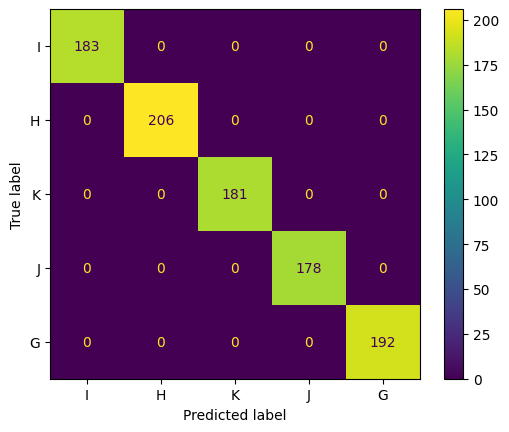

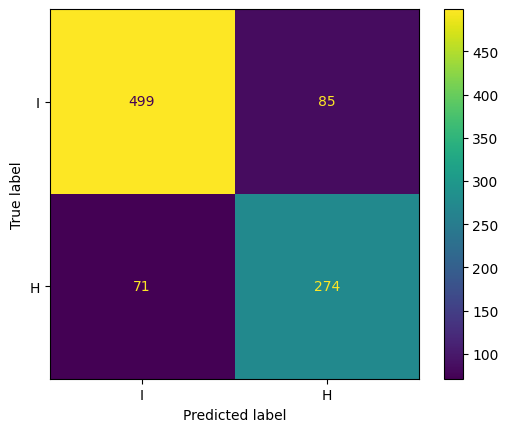

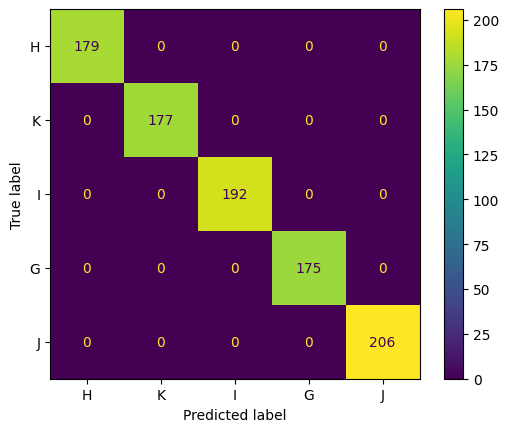

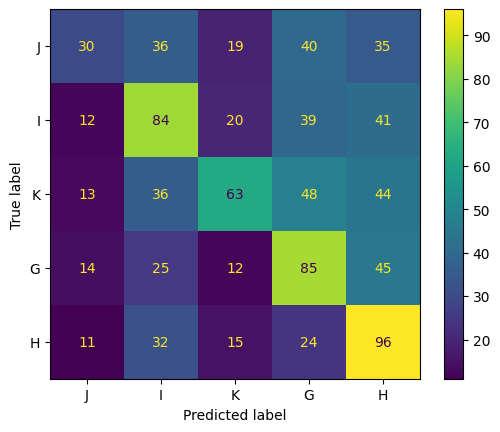

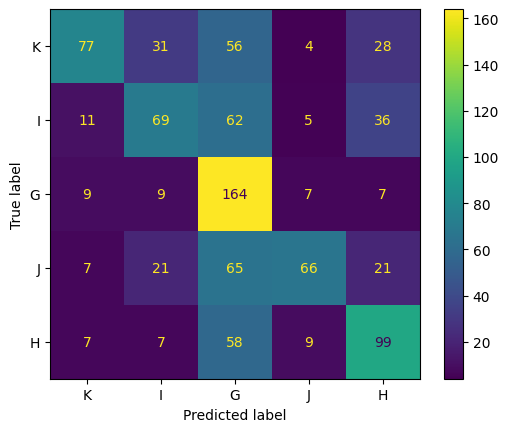

In [6]:
classifiers = []
cvs = []
conf_matrix = []
for i in range(1,6):


    y_label = f'C_{i}'
    df = num_imputed_df.dropna(subset=y_label)
    X = df.drop(columns=y_label)
    y = df.loc[:, y_label]
    non_nan_categories = list(X.loc[:, X.columns.str.contains('C_')].dropna().apply(lambda x: x.unique()).to_numpy().T)
    
    
    display(non_nan_categories)
    
    onehot_no_nans_encoder = preproc.OneHotEncoder(
        categories = non_nan_categories, 
        handle_unknown='ignore', 
        sparse_output=False
    )
    transformer = make_column_transformer(
        (onehot_no_nans_encoder, categorical_columns),
        remainder = 'passthrough'
    )

    clf = KNeighborsClassifier()
    clf
    pipe = make_pipeline(transformer, clf)
    classifiers.append(pipe)
    cv = GridSearchCV(pipe, param_grid = {"kneighborsclassifier__n_neighbors": [i for i in range(1,11)]})
    cvs.append(cv)
    

    cv.fit(X, y)
    conf_mat = ConfusionMatrixDisplay.from_estimator(
        estimator = cv.best_estimator_,
        X = X,
        y = y,
        labels = y.unique()
    )
    conf_matrix.append(conf_mat)

In [73]:
imputed_data = num_imputed_df.copy()
for i in range(1,6):
    y_label = f'C_{i}'
    df = num_imputed_df.loc[num_imputed_df[y_label].isna()]
    X = df.drop(columns=y_label)
    preds = cvs[i-1].best_estimator_.predict(X)
    imputed_data.loc[num_imputed_df[y_label].isna(), y_label] = preds

imputed_data.to_csv('imputed_data.csv')

model_data = pd.concat([raw.y, imputed_data.iloc[0:100]], axis=1)
new_imputed = imputed_data.iloc[100:]

### Correlation plot of imputed values 

/tmp/ipykernel_6010/3390136193.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  imputed_data.corr(),


Text(0.5, 1.0, 'Correlation Heatmap')

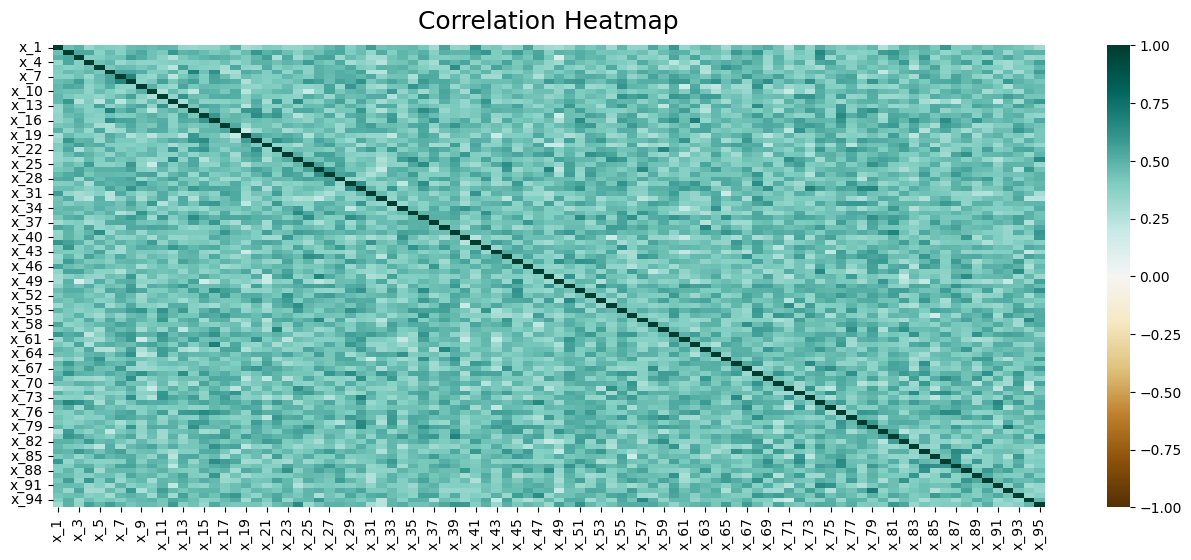

In [8]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(
    imputed_data.corr(),
    vmin=-1,
    vmax=1,
    annot=False,
    cmap="BrBG",
)
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 18}, pad=12)


# Modelling

In [62]:
linreg = linear.LinearRegression()
lasso = linear.LassoCV()
lasso_lars = linear.LassoLarsCV()
elastic_net_model = linear.ElasticNetCV()
ridge_model = linear.Ridge()
normalize = preproc.StandardScaler()
target_norm = preproc.StandardScaler(with_std=False)
knn_model = KNeighborsRegressor()
onehot_encode = preproc.OneHotEncoder(sparse_output=False)
pca = PCA()

linreg_estimator = TransformedTargetRegressor(regressor=linreg, transformer=target_norm)
lasso_lars_estimator = TransformedTargetRegressor(
    regressor=lasso_lars, transformer=target_norm
)
ridge_estimator = TransformedTargetRegressor(
    regressor=ridge_model, transformer=target_norm
)
elastic_net_estimator = TransformedTargetRegressor(
    regressor=elastic_net_model, transformer=target_norm
)

one_hot_transformer = ColumnTransformer(
    [("onehot_enc", onehot_encode, categorical_columns)], remainder="passthrough"
)

normalizer = ColumnTransformer(
    [("norm", normalize, numerical_columns)], remainder="passthrough"
)

pca_transformer = ColumnTransformer(
    [("pca", pca, numerical_columns)], remainder="passthrough"
)

ols = Pipeline([("onehot", one_hot_transformer), ("linreg", linreg_estimator)])

pca_ols = Pipeline(
    [
        ("onehot", one_hot_transformer),
        ("pca_trans", pca_transformer),
        ("linreg", linreg_estimator),
    ]
)

pca_ols_normalied = Pipeline(
    [
        ("onehot", one_hot_transformer),
        ("norm", normalizer),
        ("pca_trans", pca_transformer),
        ("linreg", linreg_estimator),
    ]
).set_output(transform="pandas")

ridge = Pipeline(
    [
        ("onehot", one_hot_transformer),
        ("norm", normalizer),
        ("ridge", ridge_estimator),
    ]
)


ridge_pca = Pipeline(
    [
        ("onehot", one_hot_transformer),
        ("norm", normalizer),
        ("pca_trans", pca_transformer),
        ("ridge", ridge_estimator),
    ]
)

elastic = Pipeline(
    [
        ("onehot", one_hot_transformer),
        ("norm", normalizer),
        ("elastic", elastic_net_estimator),
    ]
)


lassolars = Pipeline(
    [
        ("onehot", one_hot_transformer),
        ("norm", normalizer),
        ("lasso", lasso_lars_estimator),
    ]
)


In [ ]:
outer_fold = KFold(20, shuffle=True, random_state=184012)
rmse, r2 = pd.DataFrame(), pd.DataFrame()
inner_fold = KFold(5, shuffle=True, random_state=184044)
ridge_pca_search = GridSearchCV(
    ridge_pca,
    cv=inner_fold,
    param_grid={
        "pca_trans__pca__n_components": [i for i in range(20, 40)],
        "ridge__regressor__alpha": np.logspace(0, 5, base=2, num=10),
    },
    refit=True,
)


ridge_search = GridSearchCV(
    ridge,
    cv=inner_fold,
    param_grid={"ridge__regressor__alpha": np.logspace(0, 5, base=2, num=10)},
    refit=True,
    scoring="neg_root_mean_squared_error",
)

elastic.set_params(elastic__regressor__cv=inner_fold, elastic__regressor__l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
lassolars.set_params(lasso__regressor__cv=inner_fold)

X = model_data.drop(columns='y')
y = model_data['y']


def get_rmse(estimator, y, test):
    y_pred = estimator.predict(X.loc[test])
    return mean_squared_error(y.loc[test], y_pred, squared=False)


def get_r2(estimator, y, test):
    y_pred = estimator.predict(X.loc[test])
    return r2_score(y.loc[test], y_pred)


for i, (train, test) in enumerate(outer_fold.split(X, y)):
    ols.fit(X.loc[train], y.loc[train])
    y_pred = ols.predict(X.loc[test])
    ols_err = mean_squared_error(y.loc[test], y_pred=y_pred, squared=False)
    ols_r2 = r2_score(y.loc[test], y_pred=y_pred)
    rmse.loc[i, "ols"] = ols_err
    r2.loc[i, "ols"] = ols_r2
    print('ols')
    ridge_search.fit(X.loc[train], y.loc[train])
    rmse.loc[i, "ridge"] = get_rmse(ridge_search.best_estimator_, y, test)
    r2.loc[i, "ridge"] = get_r2(ridge_search.best_estimator_, y, test)

    print('ridge')
    elastic.fit(X.loc[train], y.loc[train])
    rmse.loc[i, "elastic"] = get_rmse(elastic, y, test)
    r2.loc[i, "elastic"] = get_r2(elastic, y, test)
    print('elastic')
    lassolars.fit(X.loc[train], y.loc[train])
    rmse.loc[i, "lasso"] = get_rmse(lassolars, y, test)
    r2.loc[i, "lasso"] = get_r2(lassolars, y, test)
    print('lars')

ols        33.955948
ridge      20.077059
elastic    21.440456
lasso      21.147179
dtype: float64

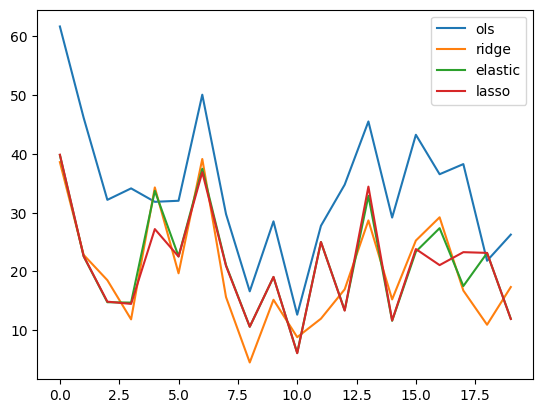

In [87]:
rmse.plot()
rmse.mean()

In [66]:
ridge_search.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=184044, shuffle=True),
             estimator=Pipeline(steps=[('onehot',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_enc',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f4463495b10>)])),
                                       ('norm',
                                        ColumnTransformer(remainder='passthrough',
                                                          transfo...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f44cc0f8dc0>)])),
                                       ('ridge',
                                        TransformedTargetRegressor(regressor=Ridge(),
                                                                   transformer=StandardScaler()))]),
             param_grid={'ridge__regressor__alpha': array([ 1.        ,  1.46973449,  2.16011948,  3.1748021 ,  4.66611616,
        6.85795186, 10.0793684 , 14.8139954 , 21.77264   , 32.        ])},
             scoring='neg_root_mean_squared_error')

In [90]:
best_model = ridge_search.best_estimator_

best_model.named_steps['ridge'].regressor_.coef_
pd.DataFrame(best_model.predict(new_imputed)).to_csv('predictions_s184012s184044.txt', index=False, header=False)

best_model.named_steps['ridge'].regressor_.solver

'auto'